# Object Detection: Bounding Box Predictions

### `Code by @Om Mule`

This `Jupyter Notebook: ` Get `predictions` from the `Object Detection` model taken from `TensorFlow Hub` & then using the predictions to draw `Bounding Boxes` on top of the `image.`

In [ ]:
# Import Libraries

# Download image & model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn
import tempfile
import numpy as np
from six.moves.urllib.request import urlopen
from six import BytesIO

# Drawing on the image
import PIL
from PIL import Image
from PIL import ImageColor, ImageDraw, ImageFont, ImageOps

# Measure Inference Time
import time

### Object Detection Models

1. [ssd + mobilenet V2](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2): `Small & fast`
2. [FasterRCNN + InceptionResNet V2](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1): `Higher Accuracy`

I am using the `FasterRCNN + InceptionResNet V2` model which has the `higher accuracy.`

The URL for the model in `TensorFlow Hub` is known as a `Handle.`

In [ ]:
# InceptionResNet v2 model with FasterRCNN architecture

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

In [ ]:
# Load the model

model = hub.load(module_handle)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Choosing the signature

In [ ]:
detector = model.signatures["default"]

### Download & Resize image

This function `downloads` an image from a `URL` & `preprocesses` it & then `saves` it to the disk.

-`tempfile package` in Python is used to create a temporary file of the `image.`


We are further providing a `display parameter` to the user to set it to True if he wants to view the downloaded image. 

In [ ]:
def display_image(image):
  # Used to display image inside Notebook
  fig = plt.figure(figsize=(20,15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256, display=False):
  # Fetch an image online, resizes & saves it locally

  # Create a JPG file instance
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()

  # Store the image data in memory buffer
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)

  # Resize the image using Pillow (if aspect ratio is different)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")

  # Save image to temporary .jpg file created earlier
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s."% filename)

  if (display):
    display_image(pil_image)
  return filename

### Select & Load the image

Load a public image from a URL, save locally & display.

Image downloaded to /tmp/tmp53o27zyk.jpg.


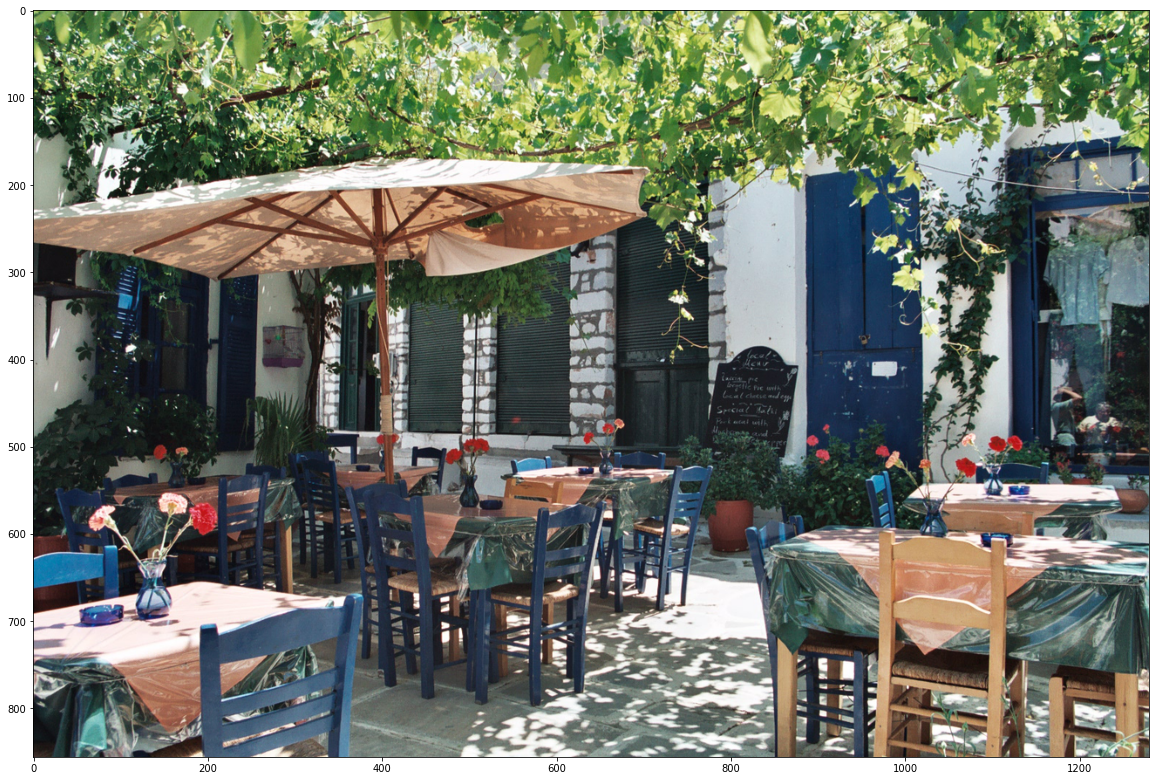

In [ ]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg" 
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, display= True)

## Draw Bounding Boxes

Functions to draw `Bounding boxes ` on the images & also assign `labels` to the objects

#### Function 1
1. `draw_bounding_box_on_image() :`  Adds bounding box on the image

In [ ]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font,
                               thickness=4, display_str_list=()):
  # Rest all is pretty clear
  # Image: Image object 
  # dislay_str_list : Class labels for each object detected

  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size

  # Scale bounding box coordinates to height & width of image
  (left, right, top, bottom) = (xmin*im_width, xmax*im_width,
                                ymin*im_height, ymax*im_height)
  # Define the edges of bounding box
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width = thickness, fill=color)
  # If the labels goes outside the image due to being on top of bounding box
  # Then put the label on bottom
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  
  # Display labels
  for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

#### Function 2

2. `draw_boxes():  `Overlays `labelled boxes` on the image with `formatted scores` & `labels names.`


#### Parameters of the function:

`class_names: ` -- List of classes for each deteced object

`max_boxes: ` -- Maximum boxes that can be shown on the image `(default = 10)`

`min_score: `-- Minimum score for bounding box to get displayed


In [ ]:
def draw_boxes(image, boxes, class_names,scores,max_boxes =10, min_score=0.1):
  colors = list(ImageColor.colormap.values())
  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()
  
  for i in range(min(boxes.shape[0], max_boxes)):
    # Minimum Score condition
    if (scores[i] >= min_score):
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

      # Draw bounding box on image
      draw_bounding_box_on_image(image_pil, ymin, xmin,
                                 ymax, xmax, color,font,
                                 display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))

  return image  

## Run detector

This function takes in the `Object Detection` model and sample image, then uses the `detector` ot detect objects.

Function also `draws boxes` this time on the `image.`

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  # Convert to tensor
  img = tf.image.decode_jpeg(img, channels=3)

  return img

In [ ]:
def run_detector(detector, path):
    # load an image tensor from a local file path
    img = load_img(path)

    # add a batch dimension in front of the tensor
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    
    # run inference using the model
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    # save the results in a dictionary
    result = {key:value.numpy() for key,value in result.items()}

    # print results
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    # draw predicted boxes over the image
    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

    # display the image
    display_image(image_with_boxes)

## Run detector on selected image above

Found 100 objects.
Inference time:  59.76225662231445


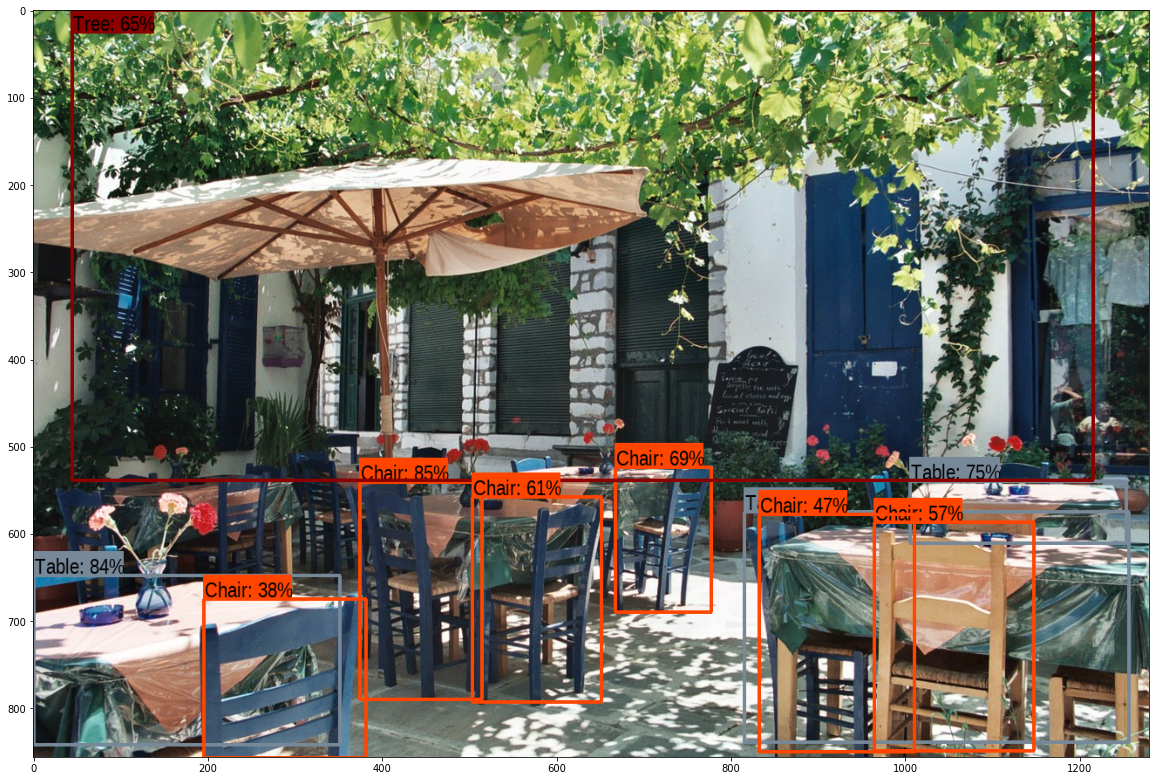

In [ ]:
run_detector(detector, downloaded_image_path)

## Inference on more images

Use more images and make inferences on the using a `simple function.`


#### Process:

1. Provide `image-url` to the function
2. Function `downloads & resizes the image` and saves `locally.`
3. Function performs `inference` on the locally stored image.

In [ ]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
]

def detect_objects(image_url):
  start_time = time.time()
  path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, path)
  end_time = time.time()
  print("Inference Time: ", end_time-start_time)

Image downloaded to /tmp/tmp2fln1t2x.jpg.
Found 100 objects.
Inference time:  4.255810260772705
Inference Time:  4.593940019607544


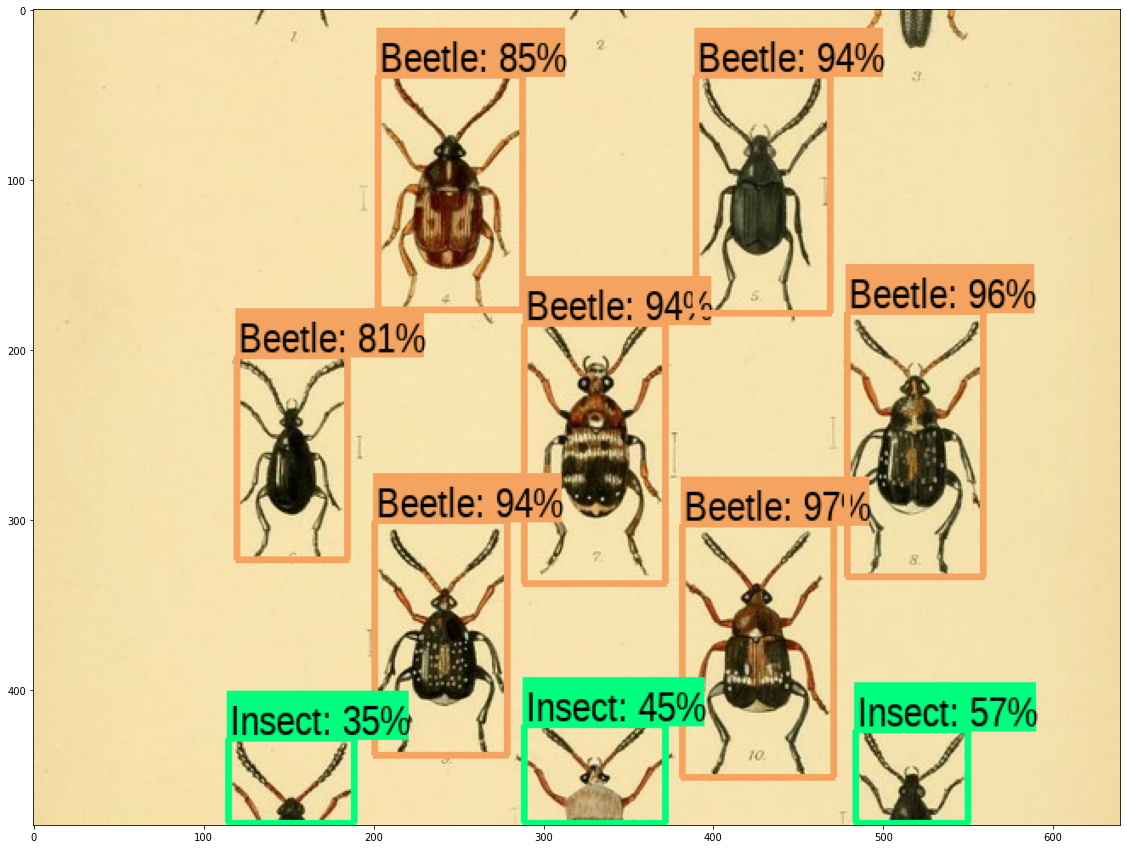

In [ ]:
detect_objects(image_urls[0])

Image downloaded to /tmp/tmprtw1y1bm.jpg.
Found 100 objects.
Inference time:  2.384812593460083
Inference Time:  2.737551212310791


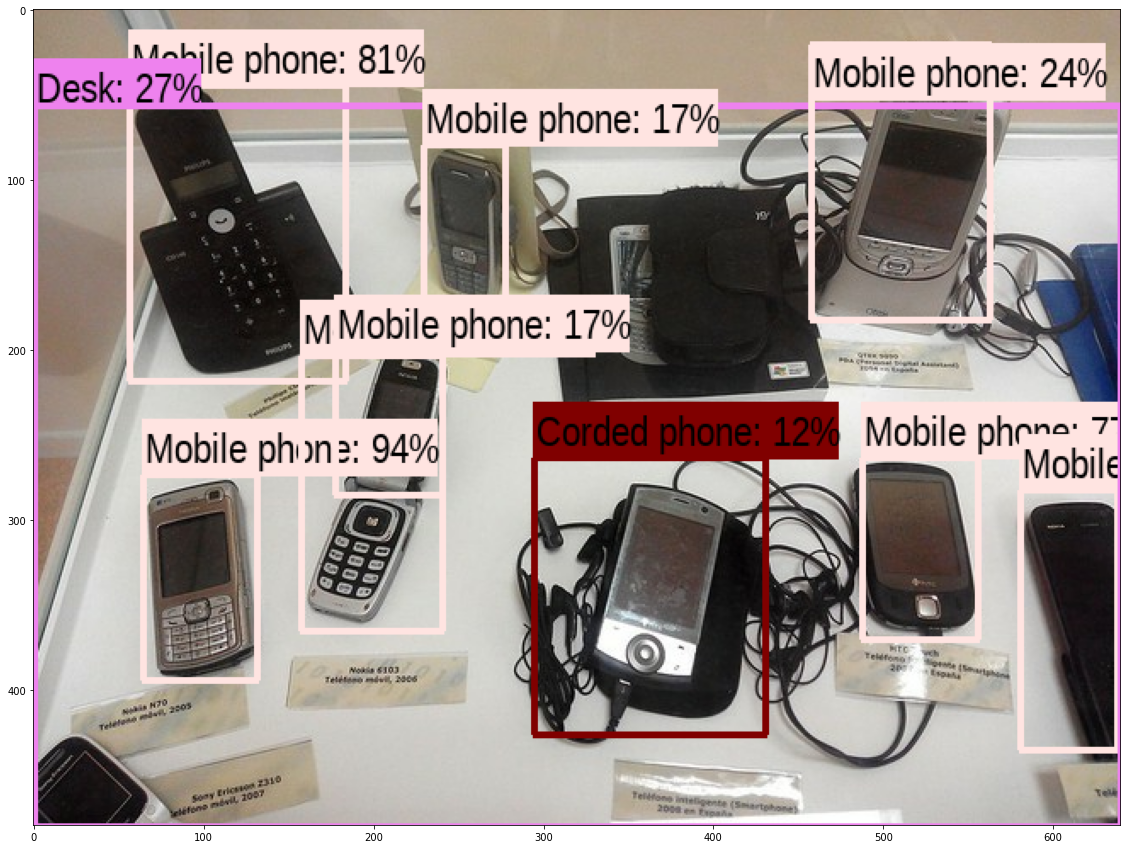

In [ ]:
detect_objects(image_urls[1])

Image downloaded to /tmp/tmpynnd0yx0.jpg.
Found 100 objects.
Inference time:  2.3255486488342285
Inference Time:  2.7428228855133057


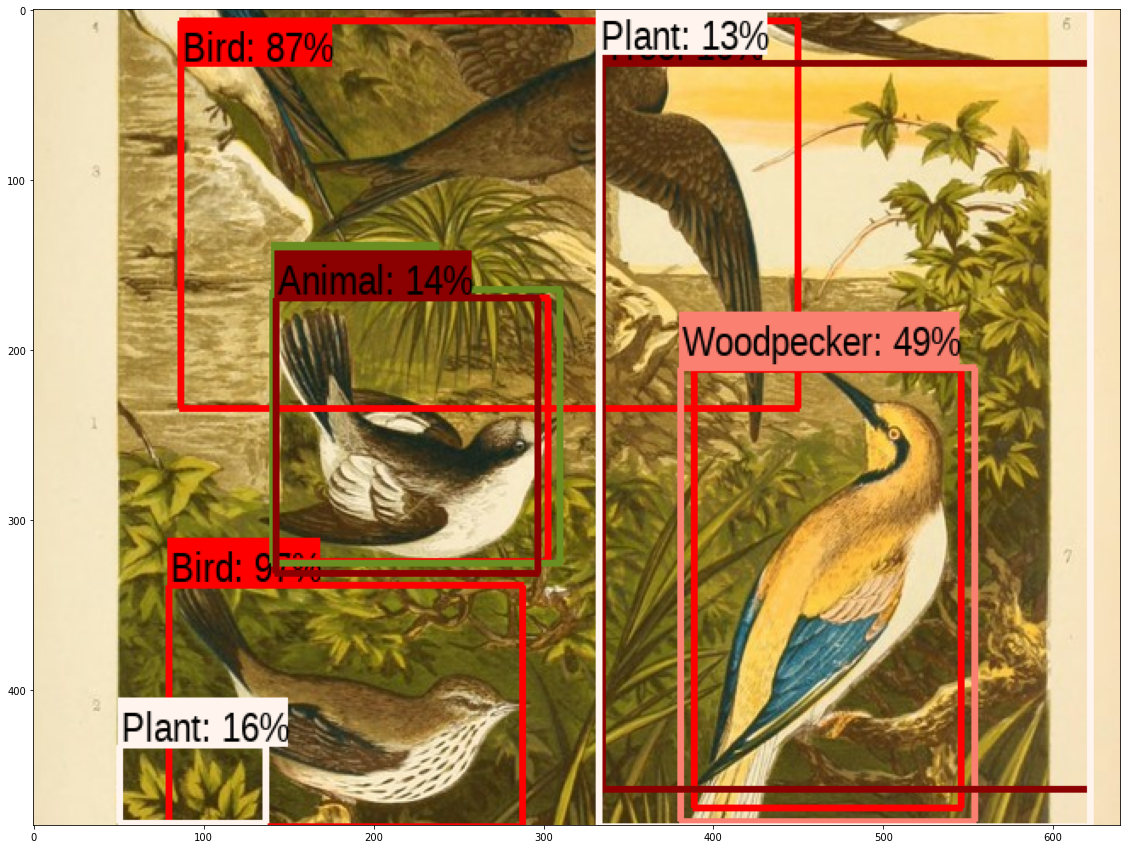

In [ ]:
detect_objects(image_urls[2])